In [1]:
import os
import logging

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns

import scipy.io
import numpy as np
import scipy as sp
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 3

from misc import *
from bcg_utils import *
_ = setup_plotting(style='ticks', context='notebook')

In [2]:
data_dir = os.path.join('..', 'data', 'scRNAseq_YangLi')
prefix = os.path.join(data_dir, 'bcg0712_complete.QC2.SCT_log_counts')
results_dir = os.path.join('results', 'scRNAseq')

# Load

In [ ]:
adata = anndata.read_h5ad(f'{prefix}.h5ad')
adata

# Feature selection

In [ ]:
# TOP_VARIABLE = 5000
# adata.var['highly_variable'] = False
# adata.var.loc[
#     adata.var['sct_variance'].sort_values().tail(TOP_VARIABLE).index,
#     'highly_variable'
# ] = True

In [ ]:
X_unscaled = adata.X.copy()
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=False)
sc.pp.neighbors(adata) # n_pcs=0
sc.tl.louvain(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.X = X_unscaled

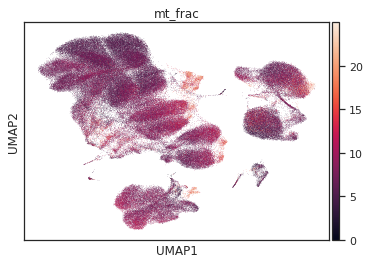

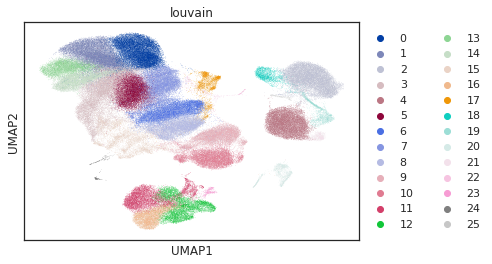

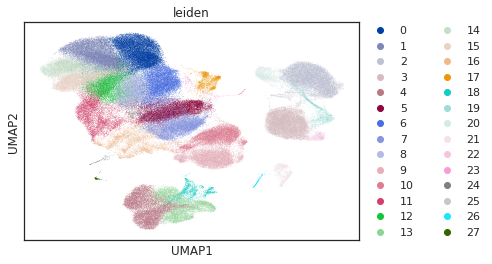

In [15]:
for color in ['mt_frac', 'louvain', 'leiden']:
    sc.pl.umap(adata, color=color)

In [6]:
adata.write(f'{prefix}.UMAP.h5ad', compression='gzip')

In [3]:
adata = anndata.read_h5ad(f'{prefix}.UMAP.h5ad')
adata

AnnData object with n_obs × n_vars = 181446 × 20856
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'status', 'assignment', 'cells', 'age', 'gender', 'time', 'stim', 'ts', 'batch', 'pool', 'bp', 'percent.mt', 'integrated_snn_res.0.5', 'seurat_clusters', 'clusters1', 'cell_ts', 'ids', 'datafile', 'groupby', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'high_mt_frac', 'leiden', 'louvain'
    var: 'features', 'n_cells', 'sct_variance', 'mean', 'std'
    uns: 'leiden', 'louvain', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
sc.tl.leiden(adata, resolution=5, key_added='leiden5')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 73 clusters and added
    'louvain5', the cluster labels (adata.obs, categorical) (0:00:40)
running Leiden clustering
    finished: found 82 clusters and added
    'leiden5', the cluster labels (adata.obs, categorical) (0:16:56)


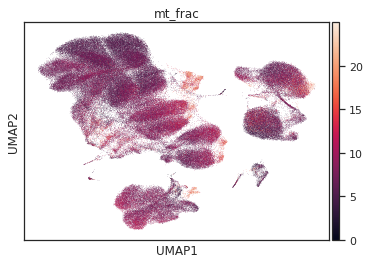

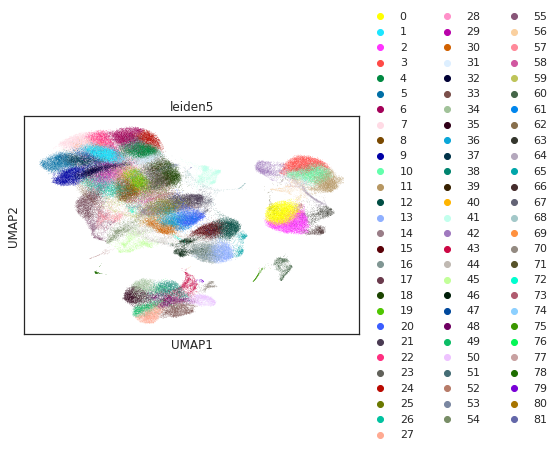

In [16]:
for color in ['mt_frac', 'leiden5']:
    sc.pl.umap(adata, color=color)

High mt_frac clusters: ['41', '67', '65', '70']
[ 9.59266537 14.14027846 15.54784222 15.55121133 18.38712496]


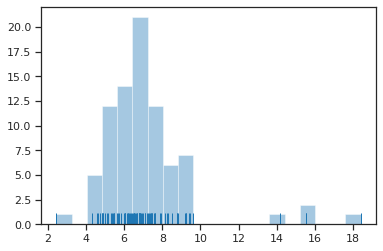

In [14]:
remove = []
HIGH_MT_FRAC = 10
CLUSTERS = 'leiden5'
mt_frac = []
for c in adata.obs[CLUSTERS].unique():
    mt_frac.append(adata.obs.loc[adata.obs[CLUSTERS] == c, 'mt_frac'].mean())
    if mt_frac[-1] > HIGH_MT_FRAC:
        remove.append(c)
    # print(c, mt_frac[-1])
print('High mt_frac clusters:', remove)
sns.distplot(mt_frac, kde=False, rug=True)
print(np.sort(mt_frac)[-5:])

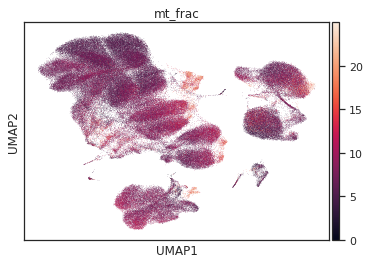

41: 2089 cells


... storing 'highlight' as categorical


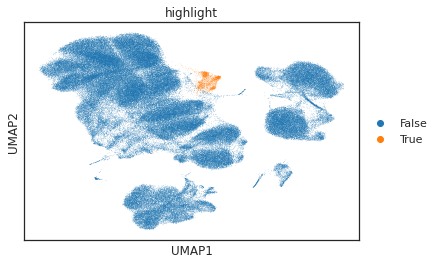

67: 695 cells


... storing 'highlight' as categorical


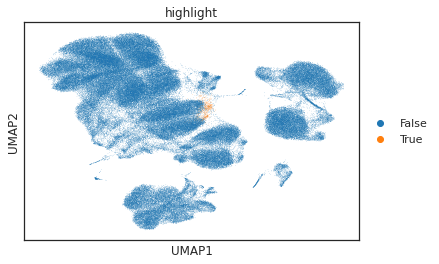

65: 800 cells


... storing 'highlight' as categorical


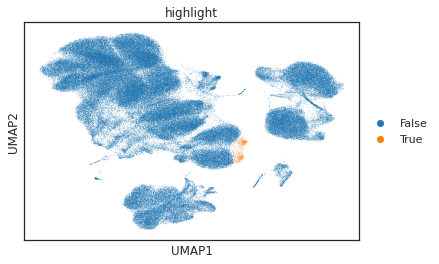

70: 442 cells


... storing 'highlight' as categorical


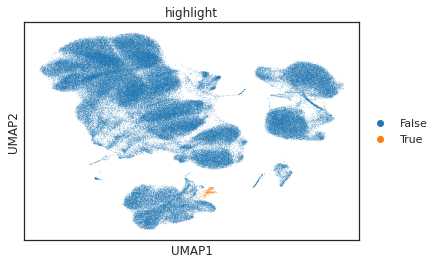

In [18]:
sc.pl.umap(adata, color='mt_frac')
for c in remove:
    mask = adata.obs[CLUSTERS] == c
    adata.obs['highlight'] = mask.astype(str)
    print(f'{c}: {mask.sum()} cells')
    sc.pl.umap(adata, color='highlight')

In [19]:
print(adata.shape)
adata = adata[~adata.obs[CLUSTERS].isin(remove)]
print(adata.shape)

(181446, 20856)
(177420, 20856)


In [21]:
adata.obs.drop(['leiden', 'louvain', 'louvain3', 'leiden3', 'louvain5', 'leiden5', 'highlight'], axis=1, inplace=True)

In [25]:
X_unscaled = adata.X.copy()
sc.pp.scale(adata)
sc.pp.pca(adata, use_highly_variable=False)
sc.pp.neighbors(adata) # n_pcs=0
sc.tl.louvain(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
adata.X = X_unscaled

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:01:57)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:52)
running Leiden clustering
    finished: found 29 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:09:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:19)


In [26]:
adata.write(f'{prefix}.UMAP.QC3.h5ad', compression='gzip')

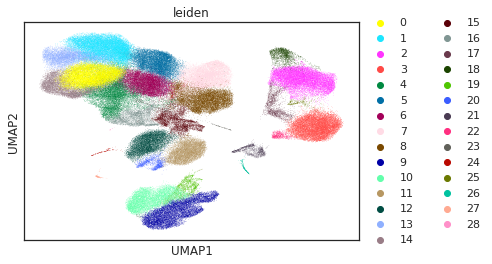

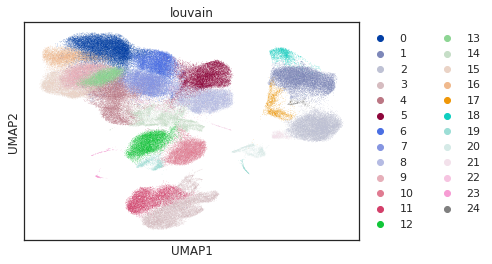

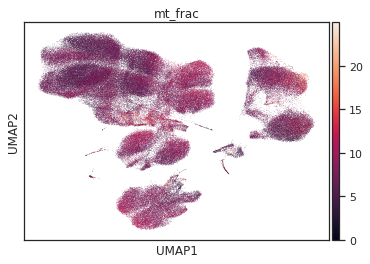

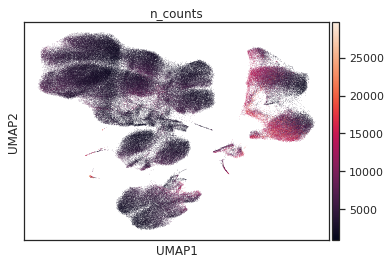

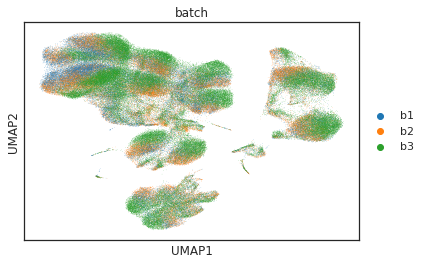

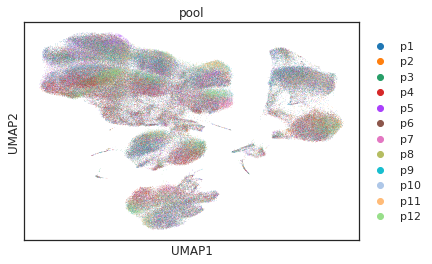

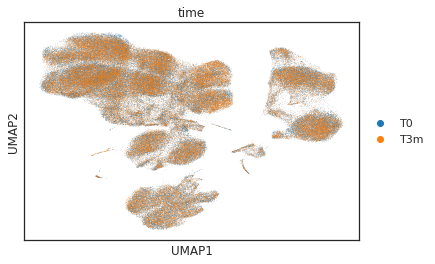

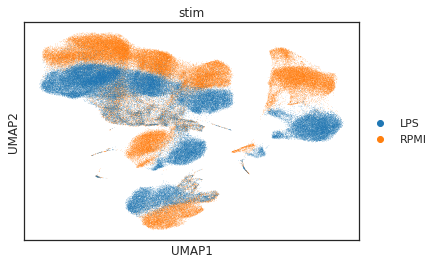

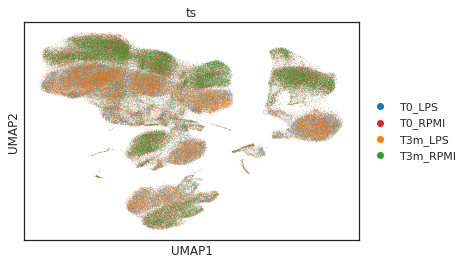

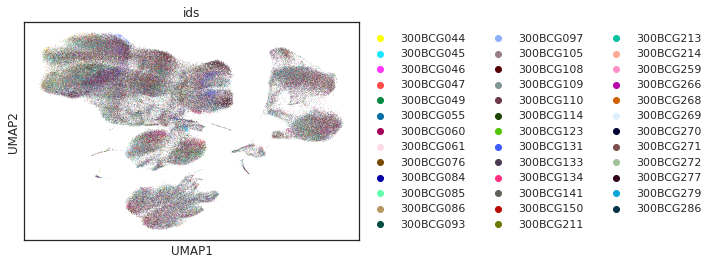

In [27]:
for color in ['leiden', 'louvain', 'mt_frac', 'n_counts', 'batch', 'pool', 'time', 'stim', 'ts', 'ids']:
    sc.pl.umap(adata, color=color, palette=np.asarray(sns.color_palette())[[0, 3, 1, 2, 4, 5, 6]].tolist() if color == 'ts' else None)